# Analysis-2

In [1]:
import math
import numpy as np
import pandas as pd
import uproot
import pyjet
import matplotlib.pyplot as plt
import time, datetime, prettytable, os, glob, tqdm, sys
import importlib


# My Packages
import myhep.particle_information_v2 as mypiv2
import myhep.analytical_function_v2 as myparsev2
import myhep.particleinfo_v1 as mypiv1
import myhep.particlefun_v1 as myafv1

%config InlineBackend.figure_format = 'retina'  # increase figure showing resolution

In [2]:
INPUT_FILE_03_5 = uproot.open('/youwei_home/SVJ_ATLAS/s-channel_mlm_dijet_ISR_v1/DP8/svj_mlm.root')['Delphes;1']
GP_03_5, JET_03_5, EVENT_03_5 = mypiv2.classGenParticle(INPUT_FILE_03_5), mypiv2.classJet(INPUT_FILE_03_5), mypiv2.classEvent(INPUT_FILE_03_5)

In [3]:
GP_03_5.length

11374

### 2. Truth Jet

In [4]:
print(time.strftime('%m/%d/%Y %a, %H:%M:%S %Z', time.localtime()))
start = datetime.datetime.now()

list_SFSP_03_5, list_SFSP_filterDM_03_5 = myparsev2.selectStableFinalStateParticle_filterDM(GP_03_5)

end = datetime.datetime.now()
print('Time =', end - start)

06/09/2021 Wed, 19:44:25 CST
The PID of dark matter are [51, 53].
There are 11374 events with stable final state.
There are 11374 events with stable final state and without DM.
Time = 0:00:21.536711


In [5]:
print(time.strftime('%m/%d/%Y %a, %H:%M:%S %Z', time.localtime()))
start = datetime.datetime.now()

list_PseudoJet_filterDM_03_5 = myparsev2.jetClustering(list_SFSP_filterDM_03_5, R=0.6, p=-1, pTmin=0)

end = datetime.datetime.now()
print('Time =', end - start)

06/09/2021 Wed, 19:45:01 CST
Time = 0:00:38.915425


In [6]:
def M(m1, pt1, eta1, phi1, m2, pt2, eta2, phi2):
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), np.sqrt(m1**2+pt1**2)*np.sinh(eta1)
    e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), np.sqrt(m2**2+pt2**2)*np.sinh(eta2)
    e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    return np.sqrt((e1+e2)**2 - (px1+px2)**2 - (py1+py2)**2 - (pz1+pz2)**2)

def MT(m1, pt1, eta1, phi1, m2, pt2, eta2, phi2):
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), np.sqrt(m1**2+pt1**2)*np.sinh(eta1)
    e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), np.sqrt(m2**2+pt2**2)*np.sinh(eta2)
    e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    ET1, ET2 = np.sqrt(m1**2 + pt1**2), np.sqrt(m2**2 + pt2**2)
    return np.sqrt((ET1+ET2)**2 - (px1+px2)**2 - (py1+py2)**2)

def mT12(m1, pt1, eta1, phi1, m2, pt2, eta2, phi2):
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), np.sqrt(m1**2+pt1**2)*np.sinh(eta1)
    e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), np.sqrt(m2**2+pt2**2)*np.sinh(eta2)
    e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    return np.sqrt((e1+e2)**2 - (pz1+pz2)**2)

### 2-1.

In [7]:
def preselectDijets_ISR_v3(_list_PseudoJet, GP, N_jet_min=2):
    _list_M_jj, _list_MT_jj, _list_mT12_jj, _list_Selected = [], [], [], []
    _list_pT1, _list_pT2, _list_Dphi = [], [], []
    _list_ltN_jet_min = []
    _list_gtDR, _list_not01, _list_equal = [], [], []
    count_gtN_jet_min = 0
    for i in range(len(_list_PseudoJet)):
        if len(_list_PseudoJet[i]) >= N_jet_min:
            count_gtN_jet_min += 1
            dfGP = GP.dataframelize(i)
            dfGP_DQ = dfGP[(abs(dfGP['PID']) == 4900101) & (dfGP['Status'] == 71)]
            DQ = dfGP_DQ[(dfGP_DQ['PID'] == 4900101)]
            DQx = dfGP_DQ[(dfGP_DQ['PID'] == -4900101)]
            _list_deta1, _list_deta2, _list_dphi1, _list_dphi2 = [], [], [], []
            for jet in _list_PseudoJet[i]:
#                 deta1 = abs(jet.eta - DQ.iloc[0, 8])
#                 deta2 = abs(jet.eta - DQx.iloc[0, 8])
                _list_deta1.append(abs(jet.eta - DQ.iloc[0, 8]))
                _list_deta2.append(abs(jet.eta - DQx.iloc[0, 8]))
                dphi1_tem = abs(jet.phi - DQ.iloc[0, 9])
                dphi2_tem = abs(jet.phi - DQx.iloc[0, 9])
                if dphi1_tem > np.pi:
                    _list_dphi1.append(2*np.pi - dphi1_tem)
                else:
                    _list_dphi1.append(dphi1_tem)
                if dphi2_tem > np.pi:
                    _list_dphi2.append(2*np.pi - dphi2_tem)
                else:
                    _list_dphi2.append(dphi2_tem)
                deta1, deta2 = np.array(_list_deta1), np.array(_list_deta2)
                dphi1, dphi2 = np.array(_list_dphi1), np.array(_list_dphi2)
                DeltaR1 = np.sqrt(deta1**2 + dphi1**2)
                DeltaR2 = np.sqrt(deta2**2 + dphi2**2)
                DeltaR1_min = np.min(DeltaR1)
                DeltaR2_min = np.min(DeltaR2)
                min1 = np.where(DeltaR1 == DeltaR1_min)
                min2 = np.where(DeltaR2 == DeltaR2_min)
            if DeltaR1_min < 0.5 and DeltaR2_min < 0.5:
                j1 = min1[0][0]
                j2 = min2[0][0]
                jet1 = _list_PseudoJet[i][j1]
                jet2 = _list_PseudoJet[i][j2]
                _list_M_jj.append(M(jet1.mass, jet1.pt, jet1.eta, jet1.phi,
                                    jet2.mass, jet2.pt, jet2.eta, jet2.phi))
                _list_MT_jj.append(MT(jet1.mass, jet1.pt, jet1.eta, jet1.phi,
                                      jet2.mass, jet2.pt, jet2.eta, jet2.phi))
                _list_mT12_jj.append(mT12(jet1.mass, jet1.pt, jet1.eta, jet1.phi,
                                          jet2.mass, jet2.pt, jet2.eta, jet2.phi))
                _list_Selected.append(i)
                _list_pT1.append(jet1.pt)
                _list_pT2.append(jet2.pt)
                Dphi = jet1.phi-jet2.phi
                if abs(Dphi) > np.pi:
                    _list_Dphi.append(2*np.pi - abs(Dphi))
                else:
                    _list_Dphi.append(abs(Dphi))
                if (j1 != 0 or j2 != 1) and (j1 != 1 or j2 !=0):
                    _list_not01.append([i, j1, j2])
                if j1 == j2:
                    _list_equal.append([i, j1, j2])
            else:
                _list_gtDR.append(i)
        else:
            _list_ltN_jet_min.append(i)
                
    _list_results1 = [_list_M_jj, _list_MT_jj, _list_mT12_jj, _list_Selected,
                     _list_pT1, _list_pT2, _list_Dphi]
    _list_results2 = [_list_ltN_jet_min, _list_gtDR, _list_not01, _list_equal,
                      count_gtN_jet_min]
    return np.array(_list_results1), _list_results2

In [8]:
print(time.strftime('%m/%d/%Y %a, %H:%M:%S %Z', time.localtime()))
start = datetime.datetime.now()

nparray_Dijets_ISR_v3, list_resultts2_v3 = preselectDijets_ISR_v3(list_PseudoJet_filterDM_03_5, GP_03_5, N_jet_min=2)

end = datetime.datetime.now()
print('Time =', end - start)

06/09/2021 Wed, 19:47:04 CST
Time = 0:03:44.623275


In [9]:
print(len(nparray_Dijets_ISR_v3))
print(len(list_resultts2_v3))

7
5


In [10]:
len(nparray_Dijets_ISR_v3[0])

11285

In [11]:
np.savetxt('svj_mlm_isr_13tev_M_jj_v3.txt', nparray_Dijets_ISR_v3[0])
np.savetxt('svj_mlm_isr_13tev_MT_jj_v3.txt', nparray_Dijets_ISR_v3[1])
np.savetxt('svj_mlm_isr_13tev_mT_jj_v3.txt', nparray_Dijets_ISR_v3[2])
np.savetxt('svj_mlm_isr_13tev_Selected_v3.txt', nparray_Dijets_ISR_v3[3])
np.savetxt('svj_mlm_isr_13tev_pT1_v3.txt', nparray_Dijets_ISR_v3[4])
np.savetxt('svj_mlm_isr_13tev_pT2_v3.txt', nparray_Dijets_ISR_v3[5])
np.savetxt('svj_mlm_isr_13tev_Dphi_jj_v3.txt', nparray_Dijets_ISR_v3[6])

### 2-0. Test

In [12]:
dfGP0 = GP_03_5.dataframelize(0)
dfGP0_DQ_Tem = dfGP0[abs(dfGP0['PID']) == 4900101]
dfGP0_DQ = dfGP0[(abs(dfGP0['PID']) == 4900101) & (dfGP0['Status'] == 71)]
dfGP0_DQ

,PID,Status,M1,M2,D1,D2,Mass,PT,Eta,Phi
818,4900101,71,809,809,839,849,10.0,42.131119,1.780161,-0.783728
838,-4900101,71,775,775,839,849,10.0,278.781555,-0.579927,1.316458


In [13]:
DQ0 = dfGP0_DQ[(dfGP0_DQ['PID'] == 4900101)]
DQx0 = dfGP0_DQ[(dfGP0_DQ['PID'] == -4900101)]
DQ0

,PID,Status,M1,M2,D1,D2,Mass,PT,Eta,Phi
818,4900101,71,809,809,839,849,10.0,42.131119,1.780161,-0.783728


In [14]:
DQx0

,PID,Status,M1,M2,D1,D2,Mass,PT,Eta,Phi
838,-4900101,71,775,775,839,849,10.0,278.781555,-0.579927,1.316458


In [15]:
idx=1

_list_deta1, _list_deta2, _list_dphi1, _list_dphi2 = [], [], [], []
_list_jj = []
for jet in list_PseudoJet_filterDM_03_5[idx]:
    _list_deta1.append(abs(jet.eta - DQ0.iloc[0, 8]))
    _list_deta2.append(abs(jet.eta - DQx0.iloc[0, 8]))
    dphi1_tem = abs(jet.phi - DQ0.iloc[0, 9])
    dphi2_tem = abs(jet.phi - DQx0.iloc[0, 9])
    if dphi1_tem > np.pi:
        _list_dphi1.append(2*np.pi - dphi1_tem)
    else:
        _list_dphi1.append(dphi1_tem)
    if dphi2_tem > np.pi:
        _list_dphi2.append(2*np.pi - dphi2_tem)
    else:
        _list_dphi2.append(dphi2_tem)
    deta1, deta2 = np.array(_list_deta1), np.array(_list_deta2)
    dphi1, dphi2 = np.array(_list_dphi1), np.array(_list_dphi2)
    DeltaR1 = np.sqrt(deta1**2 + dphi1**2)
    DeltaR2 = np.sqrt(deta2**2 + dphi2**2)
    DeltaR1_min = np.min(DeltaR1)
    DeltaR2_min = np.min(DeltaR2)
    min1 = np.where(DeltaR1 == DeltaR1_min)
    min2 = np.where(DeltaR2 == DeltaR2_min)
if DeltaR1_min < 0.5 and DeltaR2_min < 0.5:
    j1 = min1[0][0]
    j2 = min2[0][0]
    jet1 = list_PseudoJet_filterDM_03_5[idx][j1]
    jet2 = list_PseudoJet_filterDM_03_5[idx][j2]
    if j1 != 0 or j2 != 1:
        print([idx, j1, j2])
else:
    print(idx)
    
    

print(DeltaR1_min, DeltaR2_min)
print(min1[0][0], min2[0][0])
print(jet1)
print(jet2)
# DeltaR1

[1, 37, 86]
0.43492745445496866 0.4334657450070399
37 86
PseudoJet(pt=3.021, eta=2.182, phi=-0.949, mass=1.344)
PseudoJet(pt=0.493, eta=-0.147, phi=1.325, mass=0.369)


In [16]:
list_PseudoJet_filterDM_03_5[1][37]

PseudoJet(pt=3.021, eta=2.182, phi=-0.949, mass=1.344)

In [17]:
list_PseudoJet_filterDM_03_5[1][86]

PseudoJet(pt=0.493, eta=-0.147, phi=1.325, mass=0.369)

In [18]:
len(deta1)

112

In [19]:
len(list_PseudoJet_filterDM_03_5[0])

112

In [20]:
len(DeltaR1)

112

In [21]:
np.min(DeltaR1)

0.43492745445496866

In [22]:
j1 = 0
j2 = 1
if (j1 != 0 or j2 != 1) and (j1 != 1 or j2 !=0):
    print(j1, j2)
else:
    print('j1=0 or 1 and j2=0 or 1')
if j1 == j2:
    print('equal')

j1=0 or 1 and j2=0 or 1


## 3. Z' Mass

In [23]:
print(time.strftime('%m/%d/%Y %a, %H:%M:%S %Z', time.localtime()))
start = datetime.datetime.now()

m_xdxdbar_03_5, dfMxdxdbar_03_5 = myparsev2.findMxdxdbar(GP_03_5)

end = datetime.datetime.now()
print('Time =', end - start)

06/09/2021 Wed, 19:51:33 CST
All events are including 2 particles.
Time = 0:00:20.415465


## 4. Event Weight

In [24]:
weight_03_5 = np.array(EVENT_03_5.Weight)/20000
weight_03_5

array([array([6.5010718e-06], dtype=float32),
       array([6.5010718e-06], dtype=float32),
       array([6.5010718e-06], dtype=float32), ...,
       array([6.5010718e-06], dtype=float32),
       array([6.5010718e-06], dtype=float32),
       array([6.5010718e-06], dtype=float32)], dtype=object)

In [25]:
nparray_Dijets_ISR_v3.dtype

dtype('float64')

In [26]:
nparray_Dijets_ISR_v3[3].astype(np.int64)

array([    0,     1,     2, ..., 11371, 11372, 11373])

In [27]:
nparray_Dijets_ISR_v3[3].dtype

dtype('float64')

In [28]:
LUMINOSITY = 139
SVJ_MLM_13TeV = np.load('/youwei_home/SVJ_ATLAS/s-channel_mlm_v1/SVJ_MLM_13TeV.npz')
svj_mlm_weight = np.load('/youwei_home/SVJ_ATLAS/s-channel_mlm_v1/svj_mlm_weight.npy', allow_pickle=True)

## 5. Plot

In [29]:
print("There are {} events in this file.".format(GP_03_5.length))
print(len(list_resultts2_v3))
print('-'*60)
print("The events which are less than N_jet_min = {}".format(len(list_resultts2_v3[0])))
print("The events which are DeltaR > 0.5 = {}".format(len(list_resultts2_v3[1])))
print("The events which are not leading and sub-leading jets = {}".format(len(list_resultts2_v3[2])))
print("The events which are jet1 = jet2 = {}".format(len(list_resultts2_v3[3])))
print("There are {} events which are di-jets.".format(list_resultts2_v3[4]))
print("There are {} selected events.".format(len(nparray_Dijets_ISR_v3[0])))

There are 11374 events in this file.
5
------------------------------------------------------------
The events which are less than N_jet_min = 0
The events which are DeltaR > 0.5 = 89
The events which are not leading and sub-leading jets = 4019
The events which are jet1 = jet2 = 11
There are 11374 events which are di-jets.
There are 11285 selected events.


In [30]:
11374 - 89

11285

### 5-1. $M_{jj}$

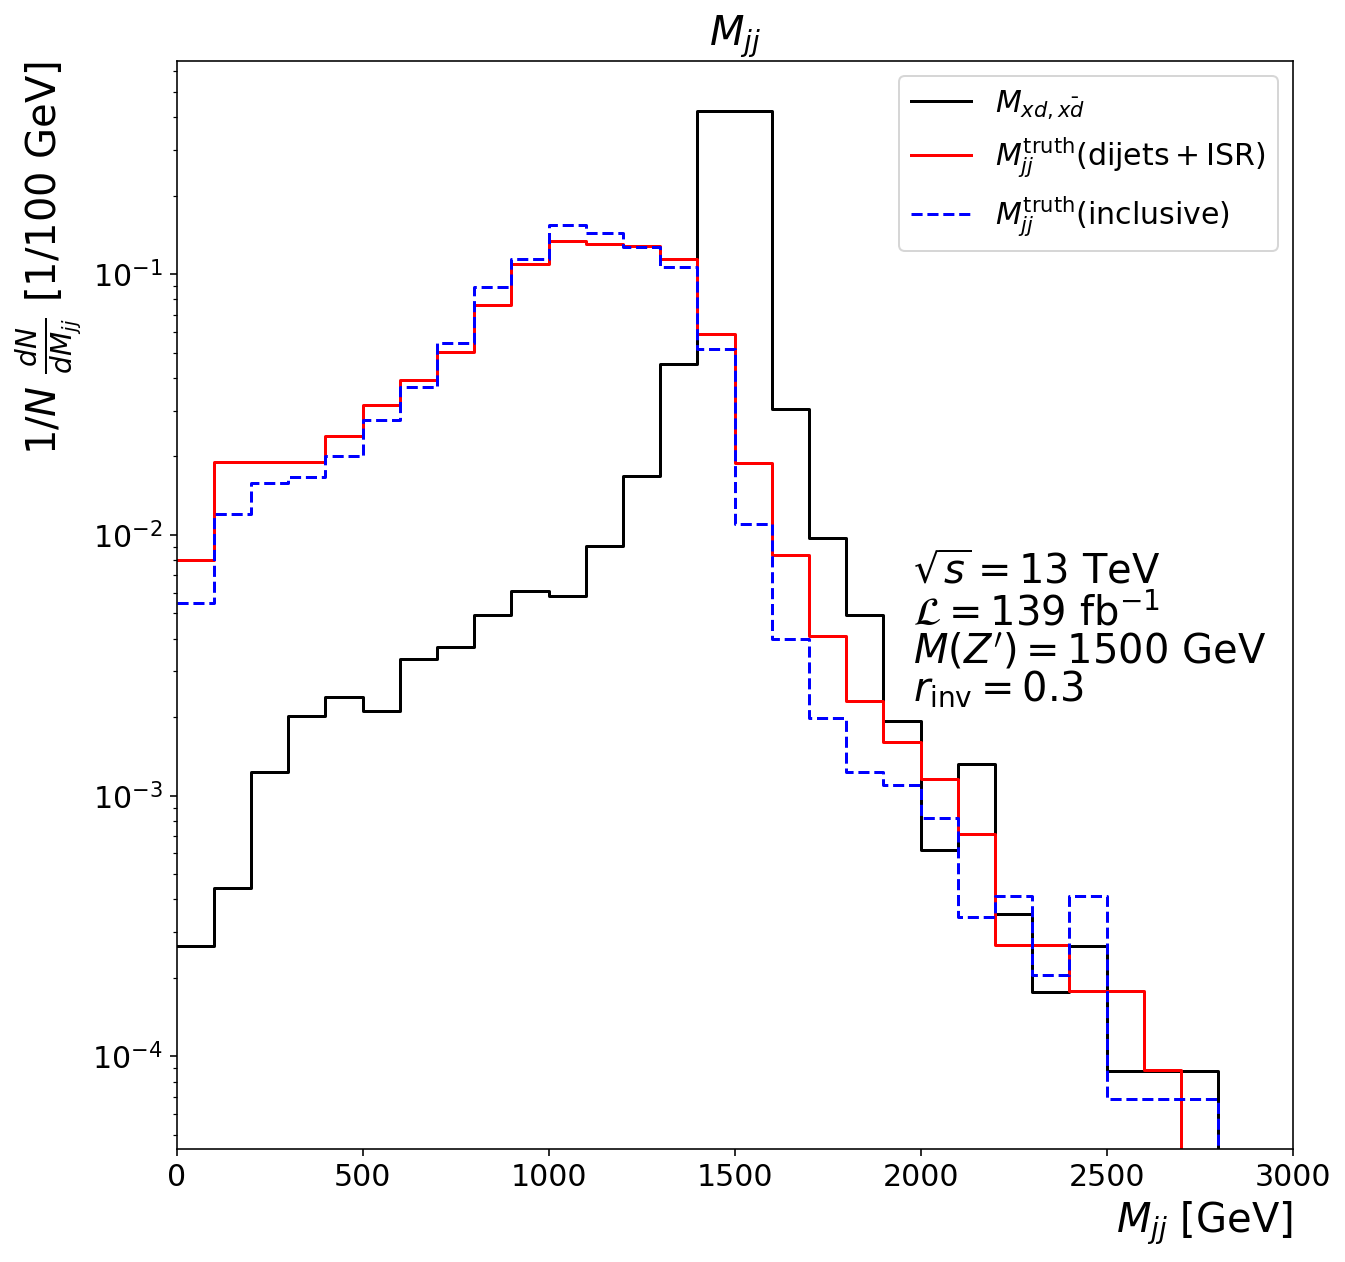

In [31]:
fig = plt.figure(figsize=(10,10))
binning = np.linspace(0, 5000, 51)

hist0_1, bins0_1 = np.histogram(m_xdxdbar_03_5, bins=binning, weights=weight_03_5)
hist0_2, bins0_2 = np.histogram(nparray_Dijets_ISR_v3[0], bins=binning,
                                weights=weight_03_5[nparray_Dijets_ISR_v3[3].astype(np.int64)]*LUMINOSITY*1000)
# hist0_3, bins0_3 = np.histogram(nparray_Dijets_ISR_v2[0], bins=binning,
#                                 weights=weight_03_5[nparray_Dijets_ISR_v2[3].astype(np.int64)]*LUMINOSITY*1000)
hist0_4, bins0_4 = np.histogram(SVJ_MLM_13TeV['M_jj'], bins=binning,
                                weights=svj_mlm_weight[SVJ_MLM_13TeV['Selected']]*LUMINOSITY*1000)

plt.step(bins0_1[:-1], hist0_1/np.sum(hist0_1), where='post', color='black', label="$M_{xd,\\bar{xd}}$")
plt.step(bins0_2[:-1], hist0_2/np.sum(hist0_2), where='post', color='red', label="$M^\mathrm{truth}_{jj}(\mathrm{dijets+ISR})$")
# plt.step(bins0_3[:-1], hist0_3/np.sum(hist0_3), where='post', color='red', label="$M^\mathrm{truth}_{jj}(\mathrm{dijets+ISR v2})$")
plt.step(bins0_4[:-1], hist0_4/np.sum(hist0_4), where='post', color='blue', linestyle='--', label="$M^\mathrm{truth}_{jj}(\mathrm{inclusive})$")

plt.text(1980, 0.0065, "$\sqrt{s} = 13$ TeV", fontsize=20)
plt.text(1980, 0.0045, '$\mathcal{L} = $'+str(LUMINOSITY)+'$\ \mathrm{fb}^{-1}$', fontsize=20)
plt.text(1980, 0.0032, '$M(Z^\prime) = 1500$ GeV', fontsize=20)
plt.text(1980, 0.0023, "$r_\mathrm{inv} = 0.3$", fontsize=20)

plt.legend(fontsize=15)
plt.yscale('log')
plt.xlim(0,3000)
plt.title('$M_{jj}$', fontsize=20)
plt.xlabel('$M_{jj}$ [GeV]', fontsize=20, horizontalalignment='right', x=1)
plt.ylabel('$1/N\ \\frac{dN}{dM_{jj}}$ [1/100 GeV]', fontsize=20, horizontalalignment='right', y=1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

### 6-2. $M_{T,jj}$

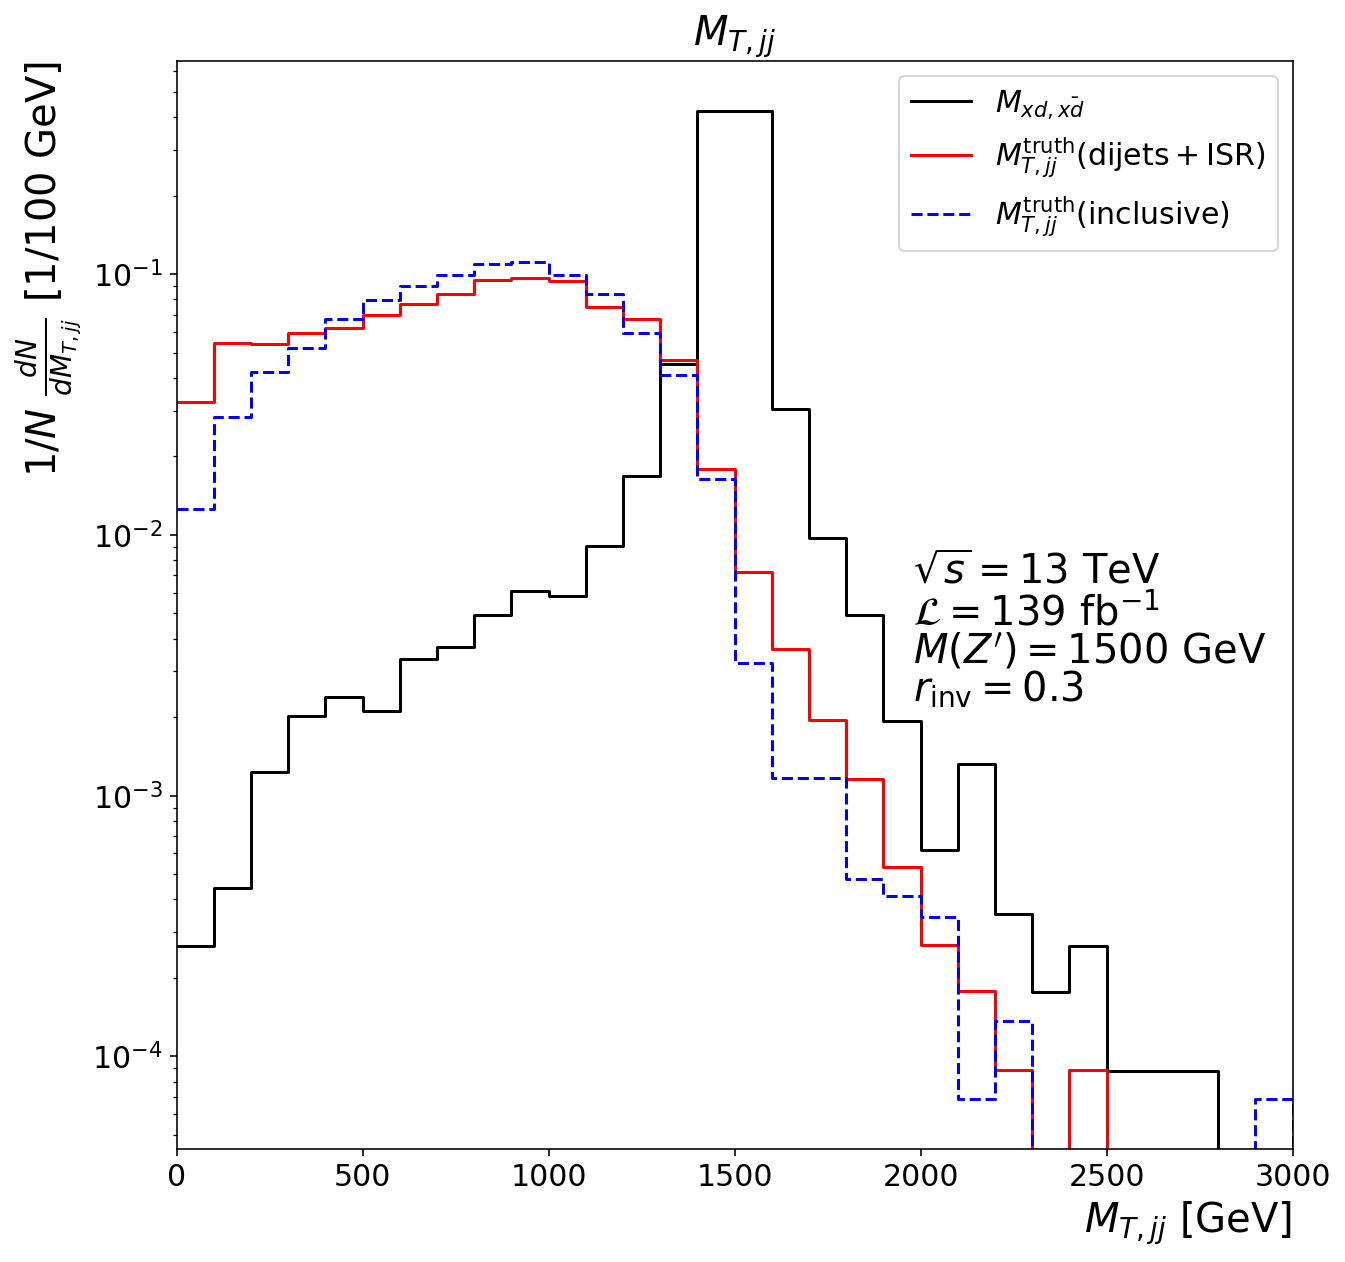

In [32]:
fig = plt.figure(figsize=(10,10))
binning = np.linspace(0, 5000, 51)

hist0_1, bins0_1 = np.histogram(m_xdxdbar_03_5, bins=binning, weights=weight_03_5)
hist0_2, bins0_2 = np.histogram(nparray_Dijets_ISR_v3[1], bins=binning,
                                weights=weight_03_5[nparray_Dijets_ISR_v3[3].astype(np.int64)]*LUMINOSITY*1000)
# hist0_3, bins0_3 = np.histogram(nparray_Dijets_ISR_v2[1], bins=binning,
#                                 weights=weight_03_5[nparray_Dijets_ISR_v2[3].astype(np.int64)]*LUMINOSITY*1000)
hist0_4, bins0_4 = np.histogram(SVJ_MLM_13TeV['MT_jj'], bins=binning,
                                weights=svj_mlm_weight[SVJ_MLM_13TeV['Selected']]*LUMINOSITY*1000)

plt.step(bins0_1[:-1], hist0_1/np.sum(hist0_1), where='post', color='black', label="$M_{xd,\\bar{xd}}$")
plt.step(bins0_2[:-1], hist0_2/np.sum(hist0_2), where='post', color='red', label="$M^\mathrm{truth}_{T,jj}(\mathrm{dijets+ISR})$")
# plt.step(bins0_3[:-1], hist0_3/np.sum(hist0_3), where='post', color='red', label="$M^\mathrm{truth}_{T,jj}(\mathrm{dijets+ISR v2})$")
plt.step(bins0_4[:-1], hist0_4/np.sum(hist0_4), where='post', color='blue', linestyle='--', label="$M^\mathrm{truth}_{T,jj}(\mathrm{inclusive})$")

plt.text(1980, 0.0065, "$\sqrt{s} = 13$ TeV", fontsize=20)
plt.text(1980, 0.0045, '$\mathcal{L} = $'+str(LUMINOSITY)+'$\ \mathrm{fb}^{-1}$', fontsize=20)
plt.text(1980, 0.0032, '$M(Z^\prime) = 1500$ GeV', fontsize=20)
plt.text(1980, 0.0023, "$r_\mathrm{inv} = 0.3$", fontsize=20)

plt.legend(fontsize=15)
plt.yscale('log')
plt.xlim(0,3000)
plt.title('$M_{T,jj}$', fontsize=20)
plt.xlabel('$M_{T,jj}$ [GeV]', fontsize=20, horizontalalignment='right', x=1)
plt.ylabel('$1/N\ \\frac{dN}{dM_{T,jj}}$ [1/100 GeV]', fontsize=20, horizontalalignment='right', y=1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

### 6-3 $m_{T,jj}$

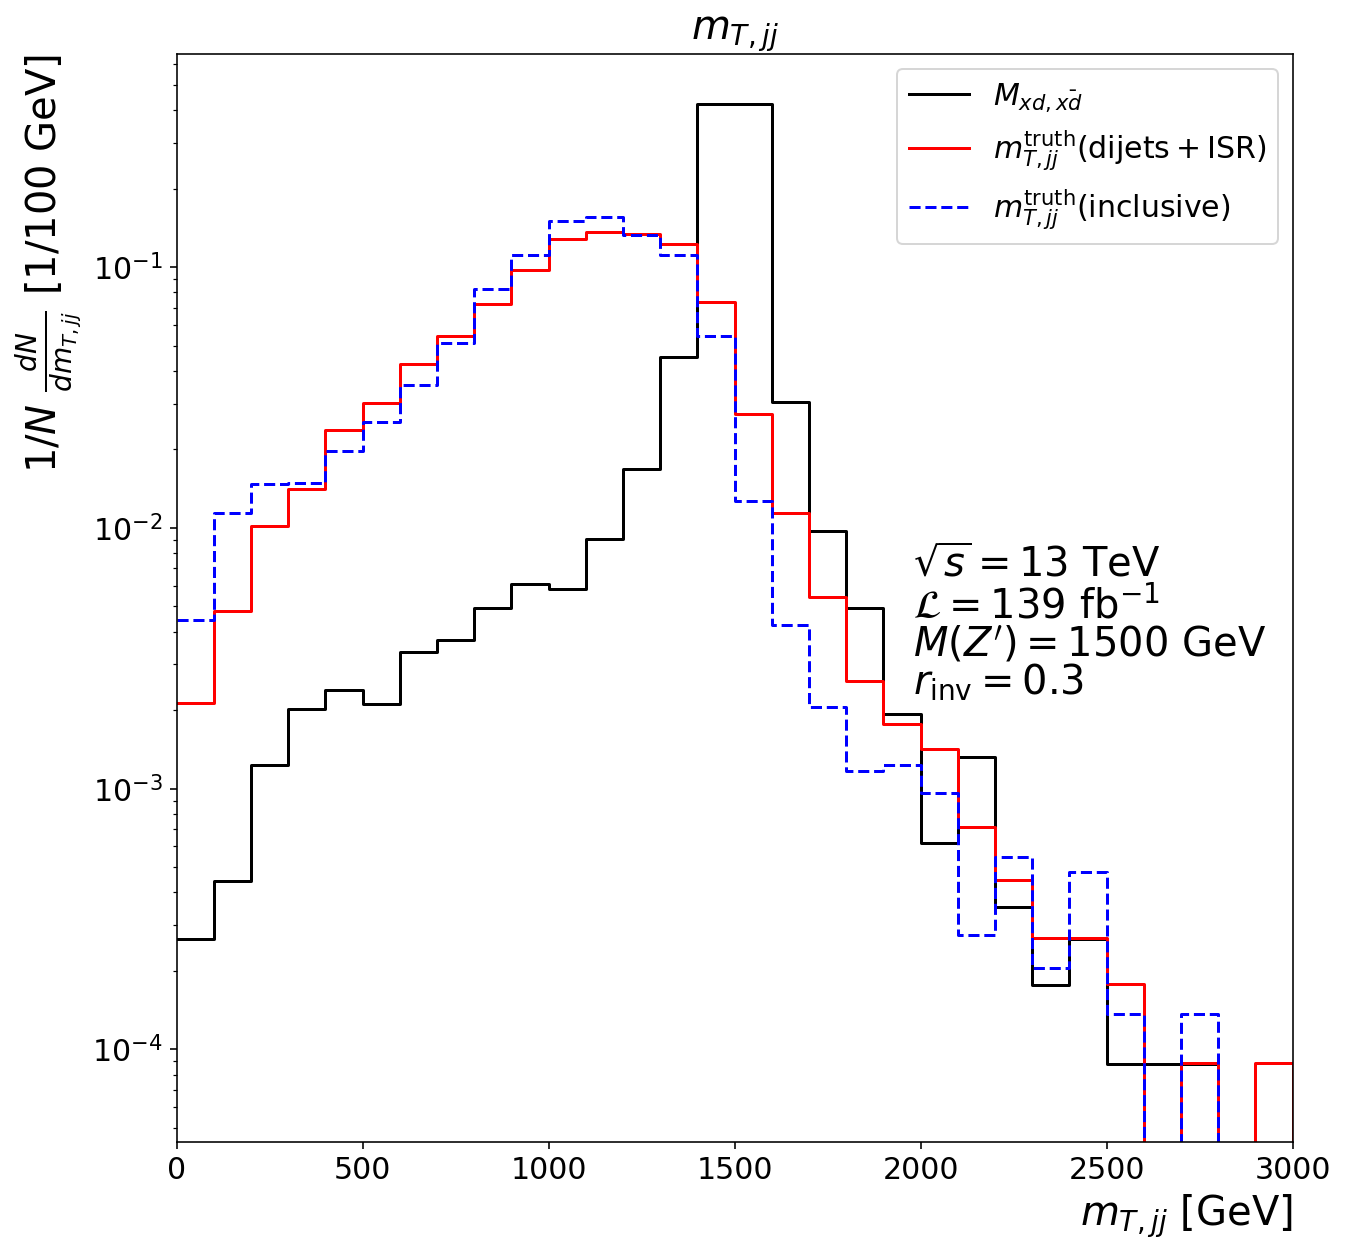

In [33]:
fig = plt.figure(figsize=(10,10))
binning = np.linspace(0, 5000, 51)

hist0_1, bins0_1 = np.histogram(m_xdxdbar_03_5, bins=binning, weights=weight_03_5)
hist0_2, bins0_2 = np.histogram(nparray_Dijets_ISR_v3[2], bins=binning,
                                weights=weight_03_5[nparray_Dijets_ISR_v3[3].astype(np.int64)]*LUMINOSITY*1000)
# hist0_3, bins0_3 = np.histogram(nparray_Dijets_ISR_v2[2], bins=binning,
#                                 weights=weight_03_5[nparray_Dijets_ISR_v2[3].astype(np.int64)]*LUMINOSITY*1000)
hist0_4, bins0_4 = np.histogram(SVJ_MLM_13TeV['mT_jj'], bins=binning,
                                weights=svj_mlm_weight[SVJ_MLM_13TeV['Selected']]*LUMINOSITY*1000)

plt.step(bins0_1[:-1], hist0_1/np.sum(hist0_1), where='post', color='black', label="$M_{xd,\\bar{xd}}$")
plt.step(bins0_2[:-1], hist0_2/np.sum(hist0_2), where='post', color='red', label="$m^\mathrm{truth}_{T,jj}(\mathrm{dijets+ISR})$")
# plt.step(bins0_3[:-1], hist0_3/np.sum(hist0_3), where='post', color='red', label="$m^\mathrm{truth}_{T,jj}(\mathrm{dijets+ISR v2})$")
plt.step(bins0_4[:-1], hist0_4/np.sum(hist0_4), where='post', color='blue', linestyle='--', label="$m^\mathrm{truth}_{T,jj}(\mathrm{inclusive})$")

plt.text(1980, 0.0065, "$\sqrt{s} = 13$ TeV", fontsize=20)
plt.text(1980, 0.0045, '$\mathcal{L} = $'+str(LUMINOSITY)+'$\ \mathrm{fb}^{-1}$', fontsize=20)
plt.text(1980, 0.0032, '$M(Z^\prime) = 1500$ GeV', fontsize=20)
plt.text(1980, 0.0023, "$r_\mathrm{inv} = 0.3$", fontsize=20)

plt.legend(fontsize=15)
plt.yscale('log')
plt.xlim(0,3000)
plt.title('$m_{T,jj}$', fontsize=20)
plt.xlabel('$m_{T,jj}$ [GeV]', fontsize=20, horizontalalignment='right', x=1)
plt.ylabel('$1/N\ \\frac{dN}{dm_{T,jj}}$ [1/100 GeV]', fontsize=20, horizontalalignment='right', y=1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

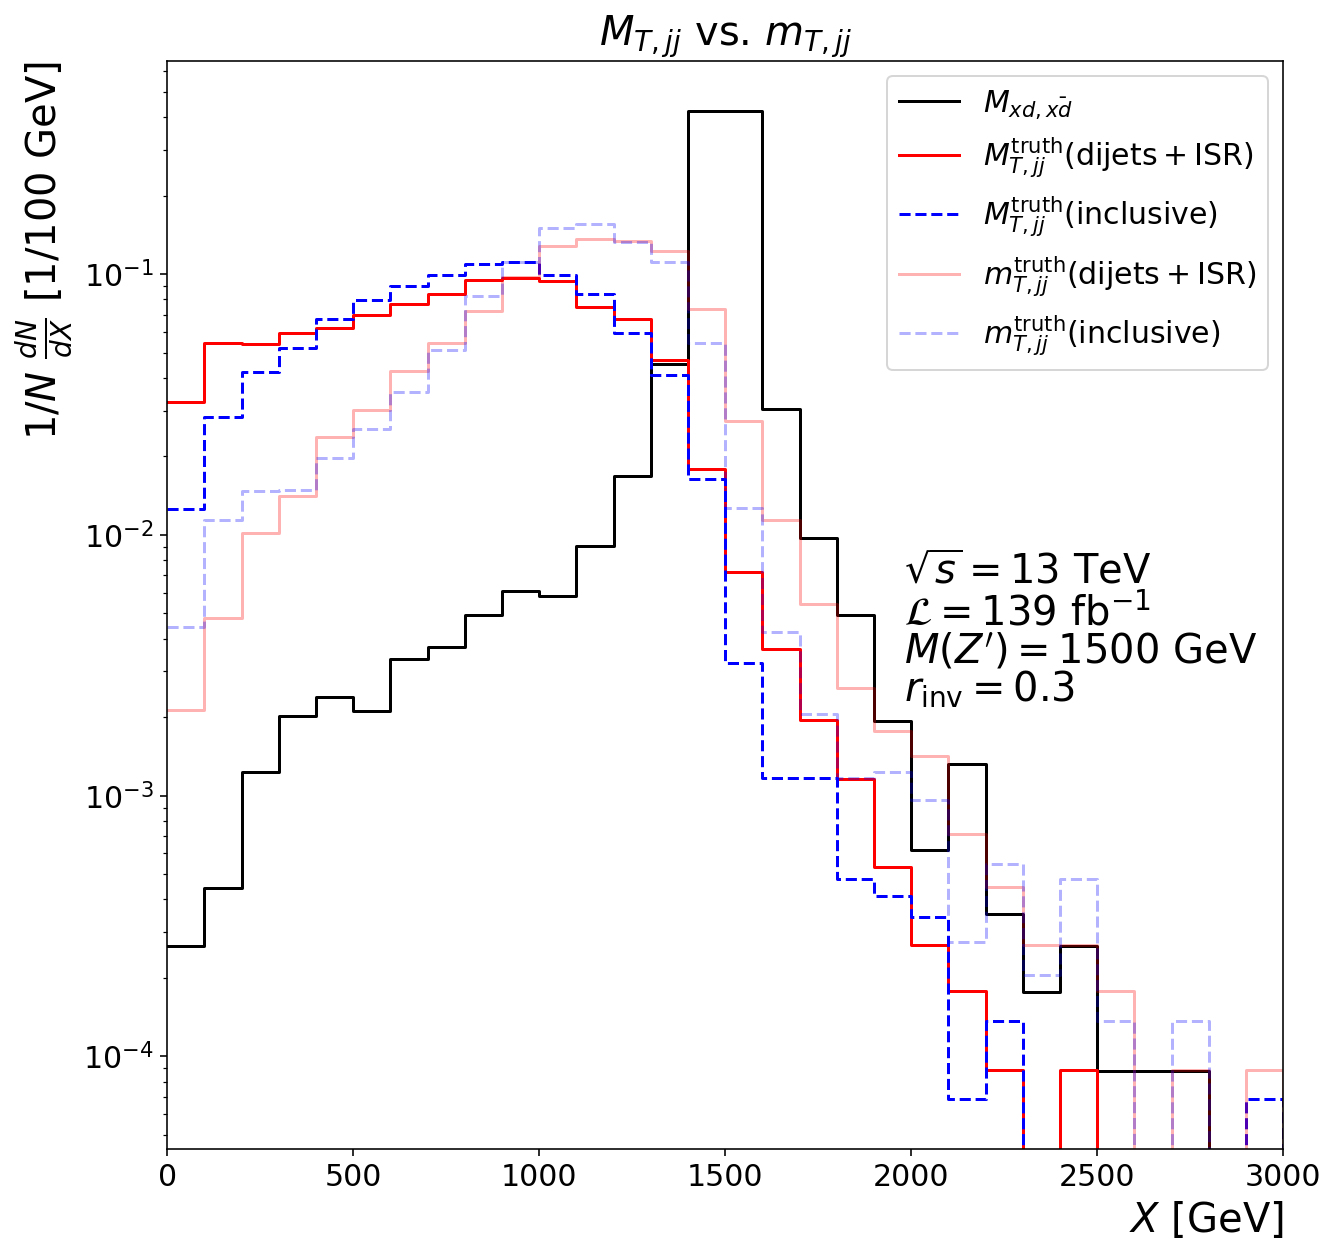

In [38]:
fig = plt.figure(figsize=(10,10))
binning = np.linspace(0, 5000, 51)

hist0_1, bins0_1 = np.histogram(m_xdxdbar_03_5, bins=binning, weights=weight_03_5)
hist0_2, bins0_2 = np.histogram(nparray_Dijets_ISR_v3[1], bins=binning,
                                weights=weight_03_5[nparray_Dijets_ISR_v3[3].astype(np.int64)]*LUMINOSITY*1000)
# hist0_3, bins0_3 = np.histogram(nparray_Dijets_ISR_v2[1], bins=binning,
#                                 weights=weight_03_5[nparray_Dijets_ISR_v2[3].astype(np.int64)]*LUMINOSITY*1000)
hist0_4, bins0_4 = np.histogram(SVJ_MLM_13TeV['MT_jj'], bins=binning,
                                weights=svj_mlm_weight[SVJ_MLM_13TeV['Selected']]*LUMINOSITY*1000)
hist0_5, bins0_5 = np.histogram(nparray_Dijets_ISR_v3[2], bins=binning,
                                weights=weight_03_5[nparray_Dijets_ISR_v3[3].astype(np.int64)]*LUMINOSITY*1000)
hist0_6, bins0_6 = np.histogram(SVJ_MLM_13TeV['mT_jj'], bins=binning,
                                weights=svj_mlm_weight[SVJ_MLM_13TeV['Selected']]*LUMINOSITY*1000)

plt.step(bins0_1[:-1], hist0_1/np.sum(hist0_1), where='post', color='black', label="$M_{xd,\\bar{xd}}$")
plt.step(bins0_2[:-1], hist0_2/np.sum(hist0_2), where='post', color='red', label="$M^\mathrm{truth}_{T,jj}(\mathrm{dijets+ISR})$")
# plt.step(bins0_3[:-1], hist0_3/np.sum(hist0_3), where='post', color='red', label="$M^\mathrm{truth}_{T,jj}(\mathrm{dijets+ISR v2})$")
plt.step(bins0_4[:-1], hist0_4/np.sum(hist0_4), where='post', color='blue', linestyle='--', label="$M^\mathrm{truth}_{T,jj}(\mathrm{inclusive})$")
plt.step(bins0_5[:-1], hist0_5/np.sum(hist0_5), where='post', color='red', alpha=0.3, label="$m^\mathrm{truth}_{T,jj}(\mathrm{dijets+ISR})$")
plt.step(bins0_6[:-1], hist0_6/np.sum(hist0_6), where='post', color='blue', alpha=0.3, linestyle='--', label="$m^\mathrm{truth}_{T,jj}(\mathrm{inclusive})$")

plt.text(1980, 0.0065, "$\sqrt{s} = 13$ TeV", fontsize=20)
plt.text(1980, 0.0045, '$\mathcal{L} = $'+str(LUMINOSITY)+'$\ \mathrm{fb}^{-1}$', fontsize=20)
plt.text(1980, 0.0032, '$M(Z^\prime) = 1500$ GeV', fontsize=20)
plt.text(1980, 0.0023, "$r_\mathrm{inv} = 0.3$", fontsize=20)

plt.legend(fontsize=15)
plt.yscale('log')
plt.xlim(0,3000)
plt.title('$M_{T,jj}$ vs. $m_{T,jj}$', fontsize=20)
plt.xlabel('$X$ [GeV]', fontsize=20, horizontalalignment='right', x=1)
plt.ylabel('$1/N\ \\frac{dN}{dX}$ [1/100 GeV]', fontsize=20, horizontalalignment='right', y=1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

### 6-4. $p_{T,1}$

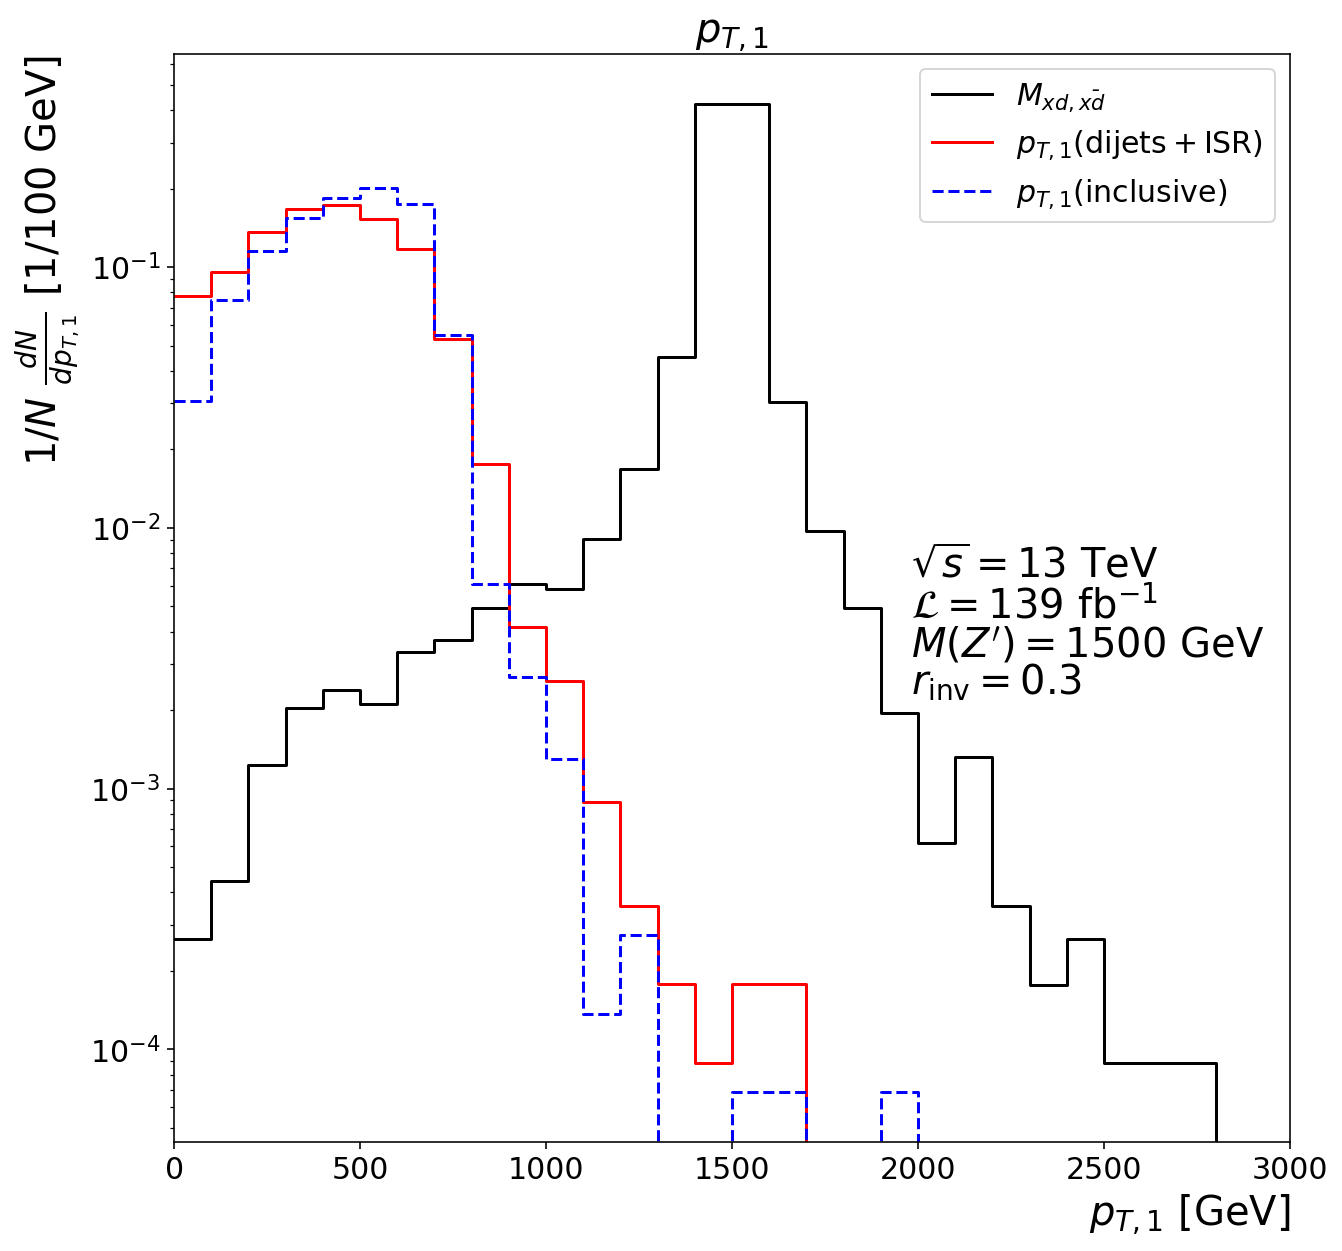

In [39]:
fig = plt.figure(figsize=(10,10))
binning = np.linspace(0, 5000, 51)

hist0_1, bins0_1 = np.histogram(m_xdxdbar_03_5, bins=binning, weights=weight_03_5)
hist0_2, bins0_2 = np.histogram(nparray_Dijets_ISR_v3[4], bins=binning,
                                weights=weight_03_5[nparray_Dijets_ISR_v3[3].astype(np.int64)]*LUMINOSITY*1000)
# hist0_3, bins0_3 = np.histogram(nparray_Dijets_ISR_v2[4], bins=binning,
#                                 weights=weight_03_5[nparray_Dijets_ISR_v2[3].astype(np.int64)]*LUMINOSITY*1000)
hist0_4, bins0_4 = np.histogram(SVJ_MLM_13TeV['pT1'], bins=binning,
                                weights=svj_mlm_weight[SVJ_MLM_13TeV['Selected']]*LUMINOSITY*1000)

plt.step(bins0_1[:-1], hist0_1/np.sum(hist0_1), where='post', color='black', label="$M_{xd,\\bar{xd}}$")
plt.step(bins0_2[:-1], hist0_2/np.sum(hist0_2), where='post', color='red', label="$p_{T,1}(\mathrm{dijets+ISR})$")
# plt.step(bins0_3[:-1], hist0_3/np.sum(hist0_3), where='post', color='red', label="$p_{T,1}(\mathrm{dijets+ISR v2})$")
plt.step(bins0_4[:-1], hist0_4/np.sum(hist0_4), where='post', color='blue', linestyle='--', label="$p_{T,1}(\mathrm{inclusive})$")

plt.text(1980, 0.0065, "$\sqrt{s} = 13$ TeV", fontsize=20)
plt.text(1980, 0.0045, '$\mathcal{L} = $'+str(LUMINOSITY)+'$\ \mathrm{fb}^{-1}$', fontsize=20)
plt.text(1980, 0.0032, '$M(Z^\prime) = 1500$ GeV', fontsize=20)
plt.text(1980, 0.0023, "$r_\mathrm{inv} = 0.3$", fontsize=20)

plt.legend(fontsize=15)
plt.yscale('log')
plt.xlim(0,3000)
plt.title('$p_{T,1}$', fontsize=20)
plt.xlabel('$p_{T,1}$ [GeV]', fontsize=20, horizontalalignment='right', x=1)
plt.ylabel('$1/N\ \\frac{dN}{dp_{T,1}}$ [1/100 GeV]', fontsize=20, horizontalalignment='right', y=1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

### 6-5. $p_{T,2}$

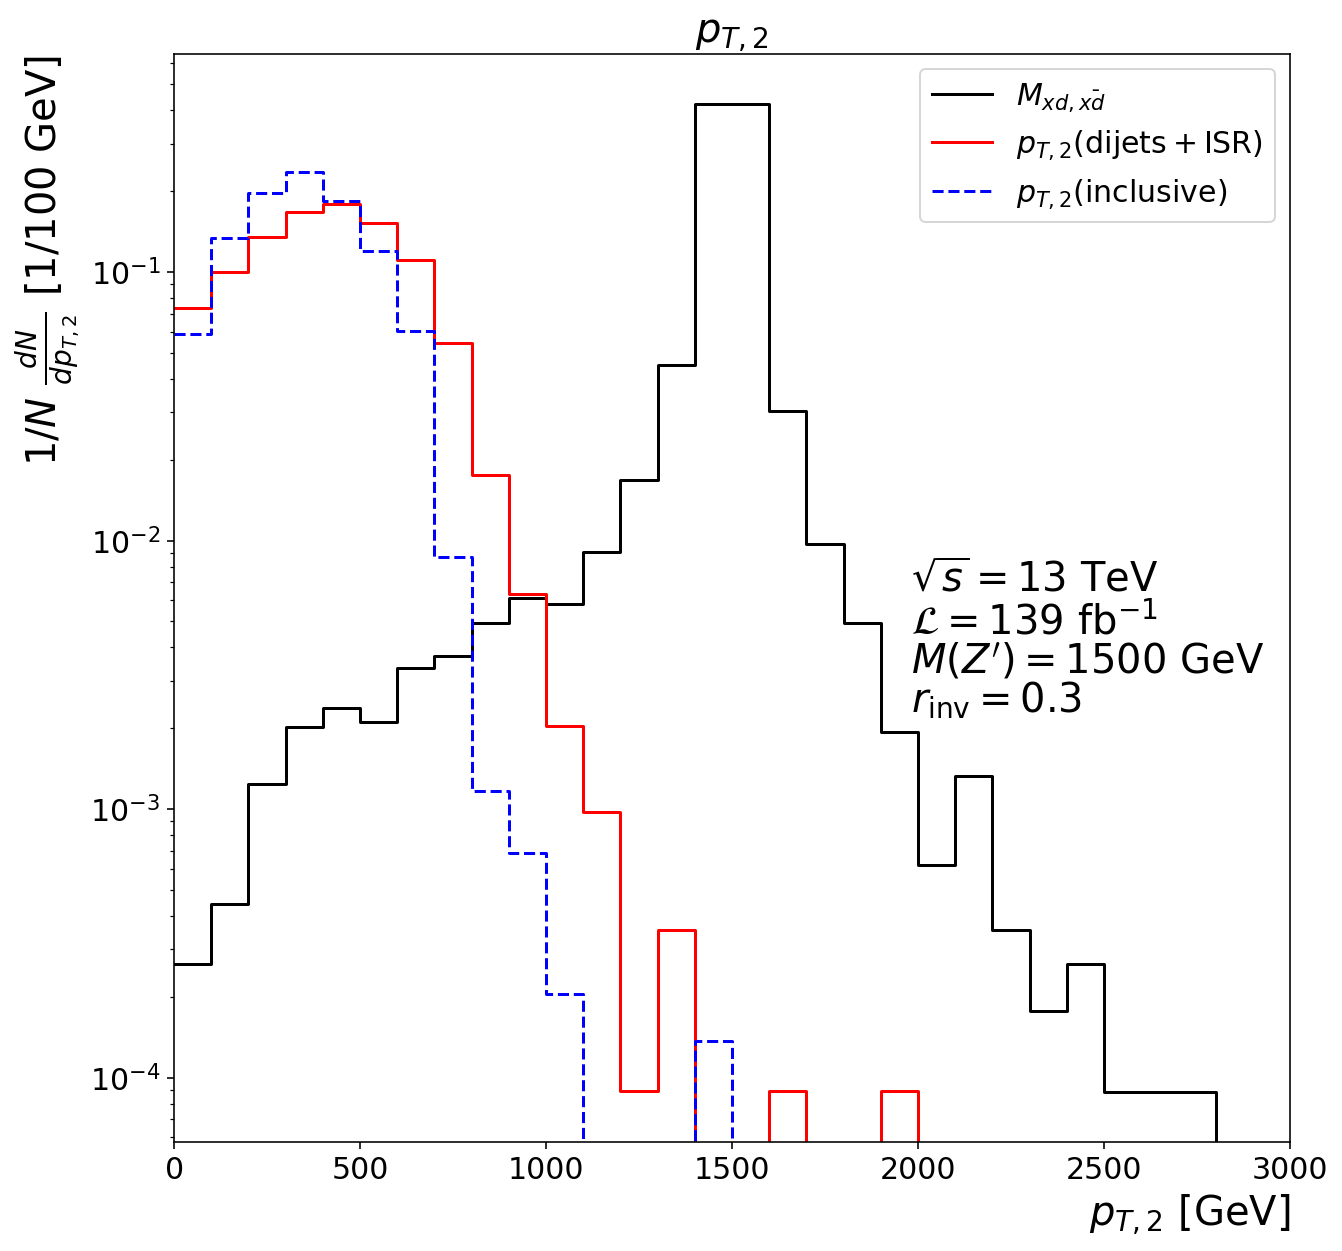

In [40]:
fig = plt.figure(figsize=(10,10))
binning = np.linspace(0, 5000, 51)

hist0_1, bins0_1 = np.histogram(m_xdxdbar_03_5, bins=binning, weights=weight_03_5)
hist0_2, bins0_2 = np.histogram(nparray_Dijets_ISR_v3[5], bins=binning,
                                weights=weight_03_5[nparray_Dijets_ISR_v3[3].astype(np.int64)]*LUMINOSITY*1000)
# hist0_3, bins0_3 = np.histogram(nparray_Dijets_ISR_v2[5], bins=binning,
#                                 weights=weight_03_5[nparray_Dijets_ISR_v2[3].astype(np.int64)]*LUMINOSITY*1000)
hist0_4, bins0_4 = np.histogram(SVJ_MLM_13TeV['pT2'], bins=binning,
                                weights=svj_mlm_weight[SVJ_MLM_13TeV['Selected']]*LUMINOSITY*1000)

plt.step(bins0_1[:-1], hist0_1/np.sum(hist0_1), where='post', color='black', label="$M_{xd,\\bar{xd}}$")
plt.step(bins0_2[:-1], hist0_2/np.sum(hist0_2), where='post', color='red', label="$p_{T,2}(\mathrm{dijets+ISR})$")
# plt.step(bins0_3[:-1], hist0_3/np.sum(hist0_3), where='post', color='red', label="$p_{T,2}(\mathrm{dijets+ISR v2})$")
plt.step(bins0_4[:-1], hist0_4/np.sum(hist0_4), where='post', color='blue', linestyle='--', label="$p_{T,2}(\mathrm{inclusive})$")

plt.text(1980, 0.0065, "$\sqrt{s} = 13$ TeV", fontsize=20)
plt.text(1980, 0.0045, '$\mathcal{L} = $'+str(LUMINOSITY)+'$\ \mathrm{fb}^{-1}$', fontsize=20)
plt.text(1980, 0.0032, '$M(Z^\prime) = 1500$ GeV', fontsize=20)
plt.text(1980, 0.0023, "$r_\mathrm{inv} = 0.3$", fontsize=20)

plt.legend(fontsize=15)
plt.yscale('log')
plt.xlim(0,3000)
plt.title('$p_{T,2}$', fontsize=20)
plt.xlabel('$p_{T,2}$ [GeV]', fontsize=20, horizontalalignment='right', x=1)
plt.ylabel('$1/N\ \\frac{dN}{dp_{T,2}}$ [1/100 GeV]', fontsize=20, horizontalalignment='right', y=1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

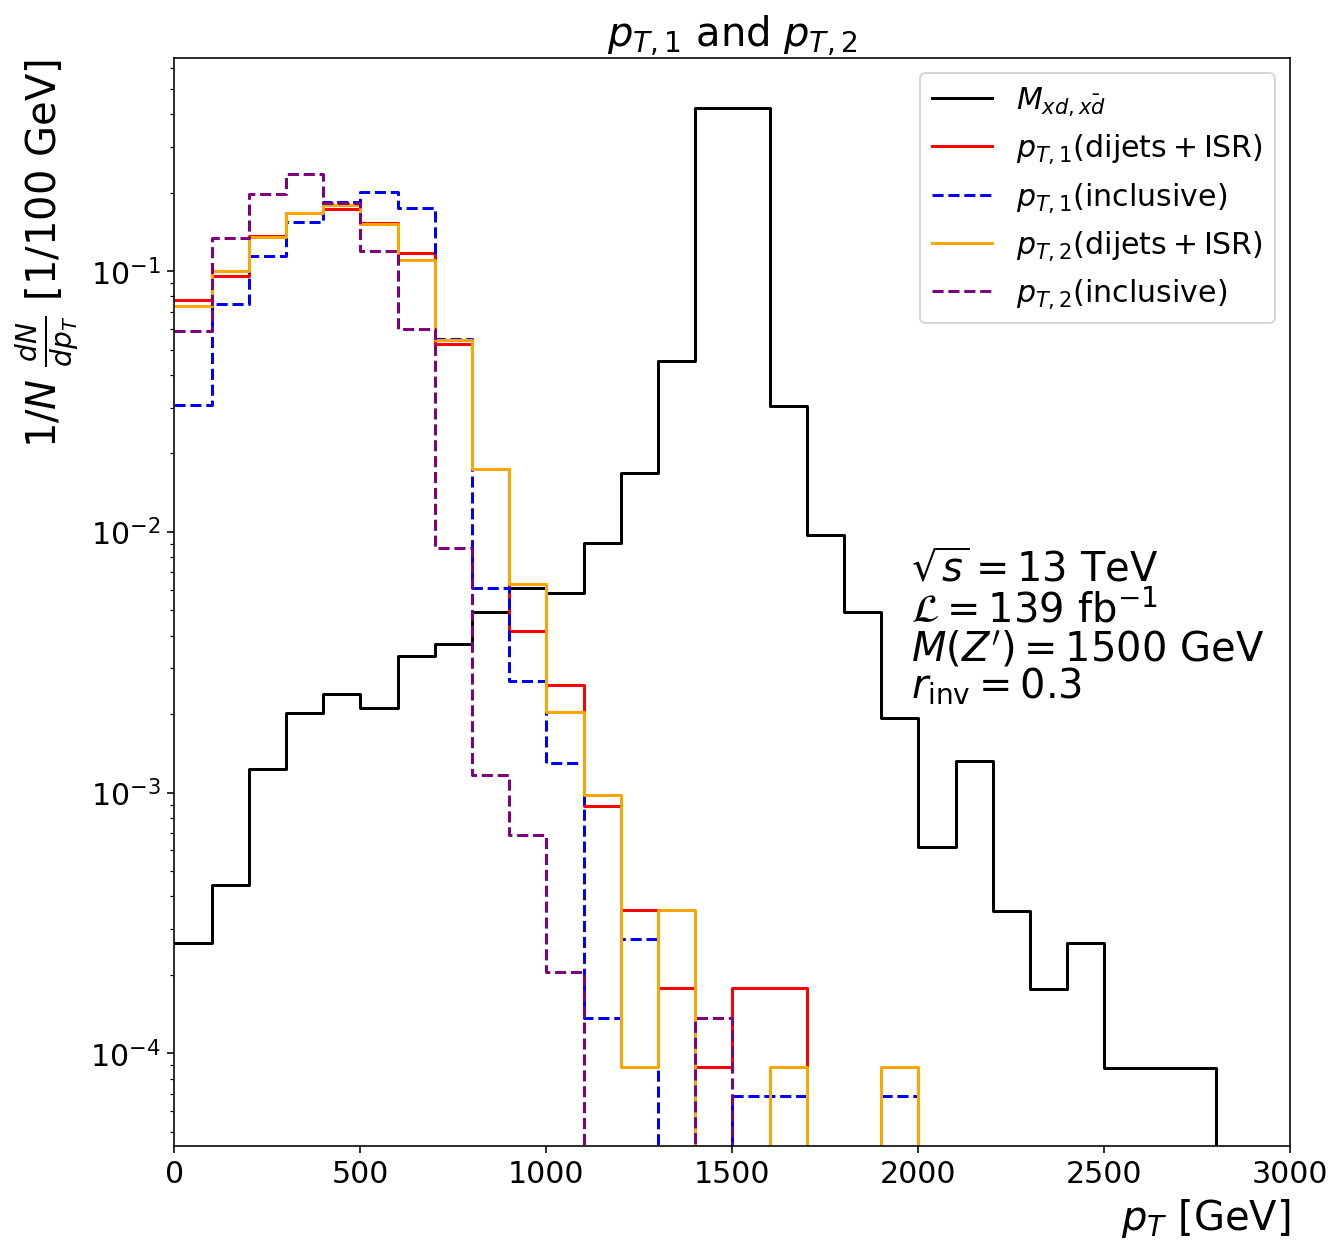

In [44]:
fig = plt.figure(figsize=(10,10))
binning = np.linspace(0, 5000, 51)

hist0_1, bins0_1 = np.histogram(m_xdxdbar_03_5, bins=binning, weights=weight_03_5)
hist0_2, bins0_2 = np.histogram(nparray_Dijets_ISR_v3[4], bins=binning,
                                weights=weight_03_5[nparray_Dijets_ISR_v3[3].astype(np.int64)]*LUMINOSITY*1000)
# hist0_3, bins0_3 = np.histogram(nparray_Dijets_ISR_v2[4], bins=binning,
#                                 weights=weight_03_5[nparray_Dijets_ISR_v2[3].astype(np.int64)]*LUMINOSITY*1000)
hist0_4, bins0_4 = np.histogram(SVJ_MLM_13TeV['pT1'], bins=binning,
                                weights=svj_mlm_weight[SVJ_MLM_13TeV['Selected']]*LUMINOSITY*1000)
hist0_5, bins0_5 = np.histogram(nparray_Dijets_ISR_v3[5], bins=binning,
                                weights=weight_03_5[nparray_Dijets_ISR_v3[3].astype(np.int64)]*LUMINOSITY*1000)
hist0_6, bins0_6 = np.histogram(SVJ_MLM_13TeV['pT2'], bins=binning,
                                weights=svj_mlm_weight[SVJ_MLM_13TeV['Selected']]*LUMINOSITY*1000)

plt.step(bins0_1[:-1], hist0_1/np.sum(hist0_1), where='post', color='black', label="$M_{xd,\\bar{xd}}$")
plt.step(bins0_2[:-1], hist0_2/np.sum(hist0_2), where='post', color='red', label="$p_{T,1}(\mathrm{dijets+ISR})$")
# plt.step(bins0_3[:-1], hist0_3/np.sum(hist0_3), where='post', color='red', label="$p_{T,1}(\mathrm{dijets+ISR v2})$")
plt.step(bins0_4[:-1], hist0_4/np.sum(hist0_4), where='post', color='blue', linestyle='--', label="$p_{T,1}(\mathrm{inclusive})$")
plt.step(bins0_5[:-1], hist0_5/np.sum(hist0_5), where='post', color='orange', label="$p_{T,2}(\mathrm{dijets+ISR})$")
plt.step(bins0_6[:-1], hist0_6/np.sum(hist0_6), where='post', color='purple', linestyle='--', label="$p_{T,2}(\mathrm{inclusive})$")

plt.text(1980, 0.0065, "$\sqrt{s} = 13$ TeV", fontsize=20)
plt.text(1980, 0.0045, '$\mathcal{L} = $'+str(LUMINOSITY)+'$\ \mathrm{fb}^{-1}$', fontsize=20)
plt.text(1980, 0.0032, '$M(Z^\prime) = 1500$ GeV', fontsize=20)
plt.text(1980, 0.0023, "$r_\mathrm{inv} = 0.3$", fontsize=20)

plt.legend(fontsize=15)
plt.yscale('log')
plt.xlim(0,3000)
plt.title('$p_{T,1}$ and $p_{T,2}$', fontsize=20)
plt.xlabel('$p_T$ [GeV]', fontsize=20, horizontalalignment='right', x=1)
plt.ylabel('$1/N\ \\frac{dN}{dp_T}$ [1/100 GeV]', fontsize=20, horizontalalignment='right', y=1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

### 6-6. $\Delta\phi(jj)$

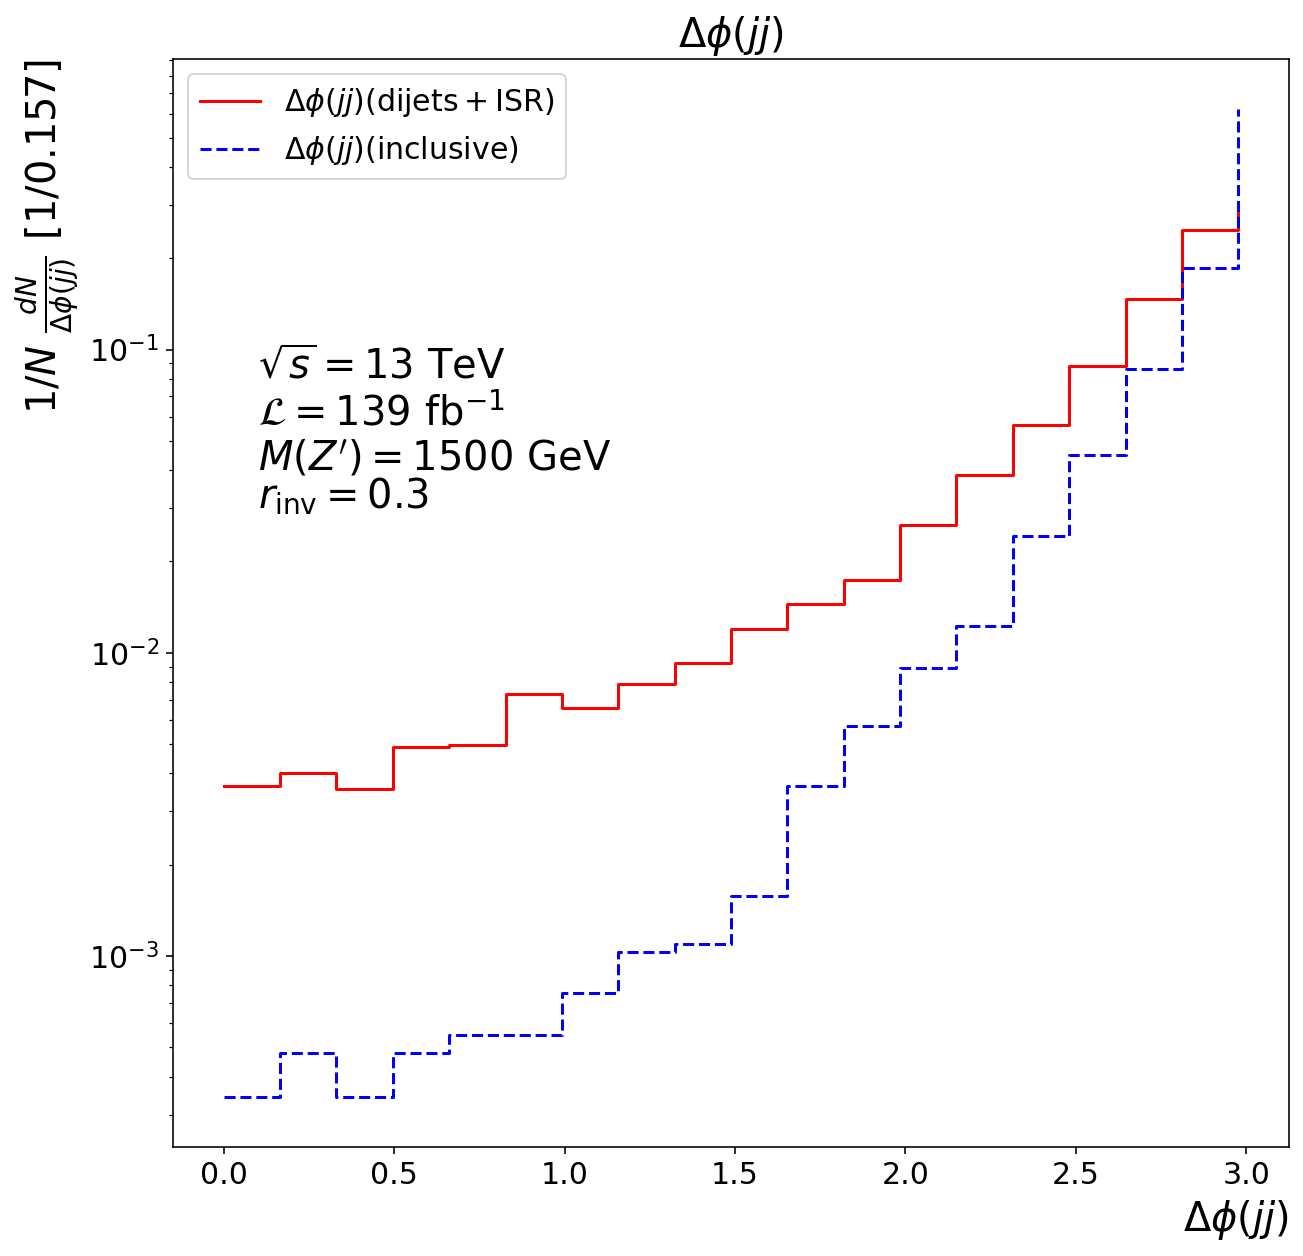

In [41]:
fig = plt.figure(figsize=(10,10))
binning = np.linspace(0, np.pi, 20)

# hist0_1, bins0_1 = np.histogram(m_xdxdbar_03_5, bins=binning, weights=weight_03_5)
hist0_2, bins0_2 = np.histogram(nparray_Dijets_ISR_v3[6], bins=binning,
                                weights=weight_03_5[nparray_Dijets_ISR_v3[3].astype(np.int64)]*LUMINOSITY*1000)
# hist0_3, bins0_3 = np.histogram(nparray_Dijets_ISR_v2[6], bins=binning,
#                                 weights=weight_03_5[nparray_Dijets_ISR_v2[3].astype(np.int64)]*LUMINOSITY*1000)
hist0_4, bins0_4 = np.histogram(SVJ_MLM_13TeV['Dphi_jj'], bins=binning,
                                weights=svj_mlm_weight[SVJ_MLM_13TeV['Selected']]*LUMINOSITY*1000)

# plt.step(bins0_1[:-1], hist0_1/np.sum(hist0_1), where='post', color='black', label="$M_{xd,\\bar{xd}}$")
plt.step(bins0_2[:-1], hist0_2/np.sum(hist0_2), where='post', color='red', label="$\Delta\phi(jj)(\mathrm{dijets+ISR})$")
# plt.step(bins0_3[:-1], hist0_3/np.sum(hist0_3), where='post', color='red', label="$\Delta\phi(jj)(\mathrm{dijets+ISR v2})$")
plt.step(bins0_4[:-1], hist0_4/np.sum(hist0_4), where='post', color='blue', linestyle='--', label="$\Delta\phi(jj)(\mathrm{inclusive})$")

plt.text(0.1, 0.08, "$\sqrt{s} = 13$ TeV", fontsize=20)
plt.text(0.1, 0.056, '$\mathcal{L} = $'+str(LUMINOSITY)+'$\ \mathrm{fb}^{-1}$', fontsize=20)
plt.text(0.1, 0.04, '$M(Z^\prime) = 1500$ GeV', fontsize=20)
plt.text(0.1, 0.03, "$r_\mathrm{inv} = 0.3$", fontsize=20)

plt.legend(fontsize=15)
plt.yscale('log')
# plt.xlim(0,3000)
plt.title('$\Delta\phi(jj)$', fontsize=20)
plt.xlabel('$\Delta\phi(jj)$', fontsize=20, horizontalalignment='right', x=1)
plt.ylabel('$1/N\ \\frac{dN}{\Delta\phi(jj)}$ [1/0.157]', fontsize=20, horizontalalignment='right', y=1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

In [42]:
np.pi/20

0.15707963267948966